# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [ ]:
%%capture
!pip install -U transformers[torch] bitsandbytes trl peft sacremoses ctranslate2

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding, 
    BitsAndBytesConfig,
    pipeline, 
    get_linear_schedule_with_warmup
)

In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tqdm.pandas() # display tqdm on pandas apply functions
print(f"Using device: {device}")

Using device: cuda


In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
class Subjectivity:
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        dataset_dict = {
            'english': {
                'train': ...
                'dev': ...
                'test': ...
            },
        }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        print(dataset['label'].value_counts(normalize=True))

    def get_baseline_model(self, model_name: str = "paraphrase-multilingual-MiniLM-L12-v2"):
        vect = SentenceTransformer(model_name)
        self.vect = vect
        return vect

    def train_baseline_model(self, vect, train_data: pd.DataFrame, test_data: pd.DataFrame, solver: str = 'saga'):
        model = LogisticRegression(class_weight="balanced", solver=solver, random_state=self.seed)
        model.fit(X=vect.encode(train_data['sentence'].values), y=train_data['label'].values)
        predictions = model.predict(X=vect.encode(test_data['sentence'].values)).tolist()

        # eval performances
        perfs = self.evaluate_model(gold_values=test_data['label'].values, predicted_values=predictions)

        return perfs

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        return class_weights

    def evaluate_model(self, gold_values, predicted_values):
        acc = accuracy_score(gold_values, predicted_values)
        m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                                   zero_division=0)
        p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                                   zero_division=0)
    
        return {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }

In [5]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

In [6]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


In [7]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


In [ ]:
notebook_login()

In [8]:
results = {}

In [9]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, weights_dtype=torch.float32, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=weights_dtype).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

def tokenize_text(texts):
    return tokenizer(texts['sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

def evaluate_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

# Baseline Model (English)

In [10]:
vect = detector.get_baseline_model(model_name="paraphrase-multilingual-MiniLM-L12-v2")
vect

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [11]:
results['baseline-english'] = detector.train_baseline_model(vect, detector.all_data['english']['train'], detector.all_data['english']['test'])

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

# Baseline Model (italian)

In [12]:
results['baseline-italian'] = detector.train_baseline_model(vect, detector.all_data['italian']['train'], detector.all_data['italian']['test'])

Batches:   0%|          | 0/51 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

# Baseline Model (multilingual)

In [13]:
results['baseline-multi'] = detector.train_baseline_model(vect, detector.train, detector.test)

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

# mDeBERTta v3 base (Arabic)

In [14]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

18

In [15]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

In [17]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [18]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.689203,0.527424,0.549998,0.539567,0.382716,0.504065,0.308458,0.571734
2,No log,0.696940,0.531407,0.550755,0.541391,0.393939,0.503876,0.323383,0.571734
3,No log,0.691782,0.543253,0.561794,0.551341,0.413174,0.518797,0.343284,0.580300
4,0.671600,0.719162,0.536002,0.544461,0.539951,0.423729,0.490196,0.373134,0.563169
5,0.671600,0.723805,0.525320,0.563321,0.544711,0.360656,0.528846,0.273632,0.582441
6,0.671600,0.741907,0.529103,0.552649,0.541447,0.383901,0.508197,0.308458,0.573876


TrainOutput(global_step=918, training_loss=0.6340754224324279, metrics={'train_runtime': 424.6211, 'train_samples_per_second': 34.563, 'train_steps_per_second': 2.162, 'total_flos': 1259508487212432.0, 'train_loss': 0.6340754224324279, 'epoch': 6.0})

{'macro_F1': 0.5538284364388012, 'macro_P': 0.5807070707070707, 'macro_R': 0.5640247678018575, 'SUBJ_F1': 0.418426103646833, 'SUBJ_P': 0.5505050505050505, 'SUBJ_R': 0.33746130030959753, 'accuracy': 0.5949197860962567}


training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

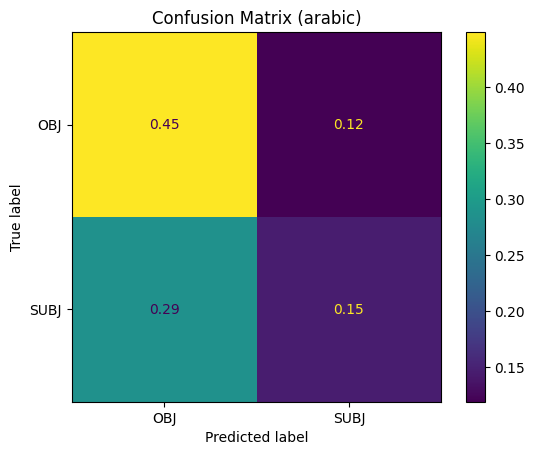

In [20]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (Bulgarian)

In [21]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5249

In [22]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [24]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [25]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.690717,0.313204,0.722045,0.502857,0.615044,0.444089,1.000000,0.445860
2,No log,0.625718,0.742015,0.749795,0.750812,0.739550,0.668605,0.827338,0.742038
3,No log,0.458185,0.789037,0.791250,0.787646,0.760148,0.780303,0.741007,0.792994
4,No log,0.437624,0.825469,0.826013,0.824995,0.804348,0.810219,0.798561,0.828025
5,No log,0.456506,0.820095,0.827250,0.816958,0.790875,0.838710,0.748201,0.824841
6,No log,0.454755,0.813095,0.812692,0.813566,0.792857,0.787234,0.798561,0.815287


TrainOutput(global_step=276, training_loss=0.4498338008272475, metrics={'train_runtime': 174.8821, 'train_samples_per_second': 25.011, 'train_steps_per_second': 1.578, 'total_flos': 334920685341096.0, 'train_loss': 0.4498338008272475, 'epoch': 6.0})

{'macro_F1': 0.7591202073227457, 'macro_P': 0.766044142614601, 'macro_R': 0.7560290177112607, 'SUBJ_F1': 0.712871287128713, 'SUBJ_P': 0.7578947368421053, 'SUBJ_R': 0.6728971962616822, 'accuracy': 0.768}


training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

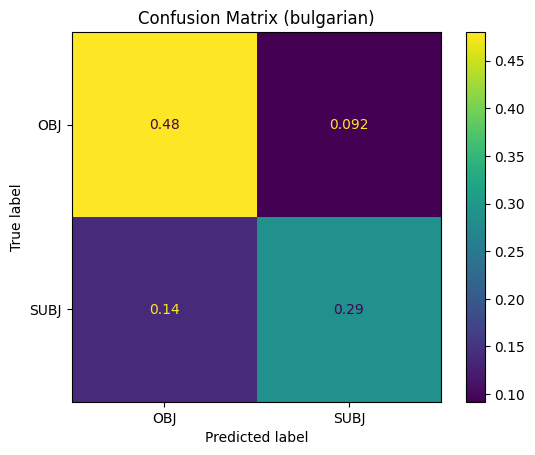

In [27]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (English)

In [48]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


4096

In [49]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [51]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [52]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.689407,0.569743,0.714987,0.623311,0.437500,0.875000,0.291667,0.610390
2,No log,0.482671,0.778519,0.779300,0.778209,0.790984,0.778226,0.804167,0.779221
3,No log,0.499558,0.792204,0.793067,0.793243,0.793103,0.821429,0.766667,0.792208
4,No log,0.540466,0.798587,0.802657,0.800845,0.793792,0.848341,0.745833,0.798701
5,No log,0.583800,0.791958,0.797804,0.794764,0.784753,0.849515,0.729167,0.792208
6,No log,0.584463,0.792145,0.795240,0.794088,0.788546,0.836449,0.745833,0.792208


TrainOutput(global_step=312, training_loss=0.4159170786539714, metrics={'train_runtime': 195.0336, 'train_samples_per_second': 25.534, 'train_steps_per_second': 1.6, 'total_flos': 445302891493920.0, 'train_loss': 0.4159170786539714, 'epoch': 6.0})

{'macro_F1': 0.6609907494625994, 'macro_P': 0.67515625, 'macro_R': 0.6522959876822751, 'SUBJ_F1': 0.47747747747747754, 'SUBJ_P': 0.53, 'SUBJ_R': 0.4344262295081967, 'accuracy': 0.7603305785123967}


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

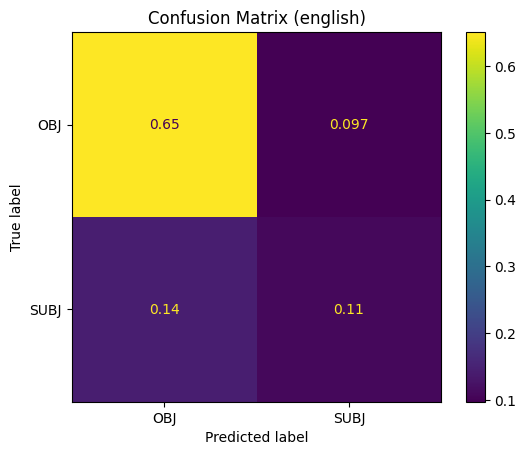

In [54]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (German)

In [55]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5240

In [56]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [58]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [59]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [60]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.687655,0.392327,0.322811,0.500000,0.000000,0.000000,0.000000,0.645621
2,No log,0.538503,0.723089,0.735112,0.756237,0.689815,0.577519,0.856322,0.727088
3,No log,0.495120,0.787952,0.782820,0.797464,0.736559,0.691919,0.787356,0.800407
4,No log,0.519152,0.783018,0.781662,0.784501,0.721591,0.713483,0.729885,0.800407
5,No log,0.560239,0.779396,0.779765,0.779035,0.714697,0.716763,0.712644,0.798371
6,No log,0.575992,0.771954,0.768676,0.776333,0.711111,0.688172,0.735632,0.788187


TrainOutput(global_step=300, training_loss=0.4198262023925781, metrics={'train_runtime': 177.0575, 'train_samples_per_second': 27.11, 'train_steps_per_second': 1.694, 'total_flos': 404540502451200.0, 'train_loss': 0.4198262023925781, 'epoch': 6.0})

{'macro_F1': 0.8217188476891262, 'macro_P': 0.8139204545454546, 'macro_R': 0.8347683967152993, 'SUBJ_F1': 0.7698744769874477, 'SUBJ_P': 0.71875, 'SUBJ_R': 0.8288288288288288, 'accuracy': 0.8367952522255193}


training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

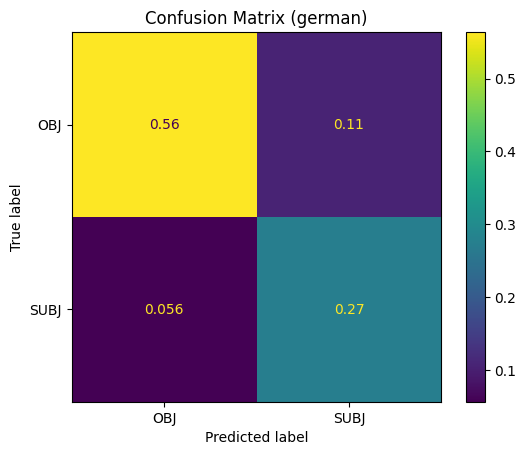

In [61]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (italian)

In [62]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5094

In [63]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

In [65]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [66]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [67]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.681801,0.515858,0.682238,0.541427,0.182692,0.612903,0.107345,0.745127
2,No log,0.525715,0.673524,0.692214,0.746489,0.597656,0.456716,0.864407,0.691154
3,No log,0.626910,0.739306,0.735472,0.743699,0.620879,0.604278,0.638418,0.793103
4,No log,0.651582,0.744813,0.735306,0.759703,0.637306,0.588517,0.694915,0.790105
5,0.432600,0.788276,0.746273,0.741322,0.752173,0.632153,0.610526,0.655367,0.797601
6,0.432600,0.792179,0.748976,0.740909,0.760175,0.640212,0.601990,0.683616,0.796102


TrainOutput(global_step=606, training_loss=0.391674542191005, metrics={'train_runtime': 323.3994, 'train_samples_per_second': 29.926, 'train_steps_per_second': 1.874, 'total_flos': 810681283261944.0, 'train_loss': 0.391674542191005, 'epoch': 6.0})

{'macro_F1': 0.7047943178455165, 'macro_P': 0.7096616288319157, 'macro_R': 0.7673193946013419, 'SUBJ_F1': 0.6236559139784946, 'SUBJ_P': 0.4915254237288136, 'SUBJ_R': 0.8529411764705882, 'accuracy': 0.7270955165692008}


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

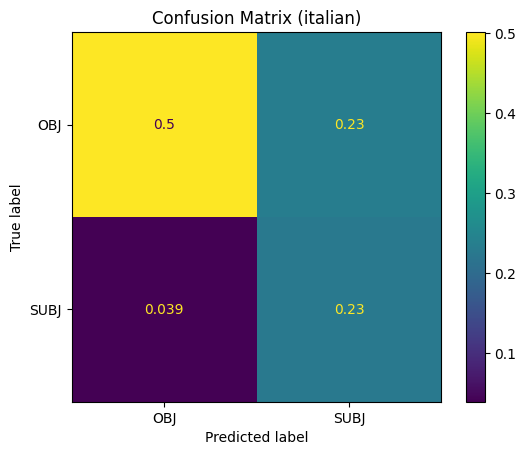

In [68]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[language] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (multilingual)

In [79]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


4832

In [80]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.train)
dev_data = Dataset.from_pandas(detector.dev)
test_data = Dataset.from_pandas(detector.test)

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.train)

Map:   0%|          | 0/6418 [00:00<?, ? examples/s]

Map:   0%|          | 0/2401 [00:00<?, ? examples/s]

Map:   0%|          | 0/2332 [00:00<?, ? examples/s]

In [82]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-multilingual",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [83]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

In [84]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.503291,0.739046,0.745748,0.758450,0.714483,0.624598,0.834586,0.741358
2,0.606500,0.528519,0.745698,0.744024,0.755138,0.706404,0.652411,0.770140,0.751770
3,0.463100,0.658301,0.732819,0.731082,0.735285,0.678515,0.660896,0.697100,0.743857
4,0.394000,0.769232,0.725545,0.732651,0.721536,0.652273,0.692400,0.616541,0.745106
5,0.347500,0.753815,0.743778,0.741408,0.748084,0.695116,0.666667,0.726101,0.753020
6,0.347500,0.834548,0.747481,0.753033,0.743878,0.682379,0.714454,0.653061,0.764265


TrainOutput(global_step=2412, training_loss=0.430092667663473, metrics={'train_runtime': 1112.9406, 'train_samples_per_second': 34.6, 'train_steps_per_second': 2.167, 'total_flos': 3434471781111288.0, 'train_loss': 0.430092667663473, 'epoch': 6.0})

{'macro_F1': 0.6974067803767559, 'macro_P': 0.6969229570193767, 'macro_R': 0.7165961692167395, 'SUBJ_F1': 0.6353829557713053, 'SUBJ_P': 0.5582938388625592, 'SUBJ_R': 0.737171464330413, 'accuracy': 0.7101200686106347}


training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

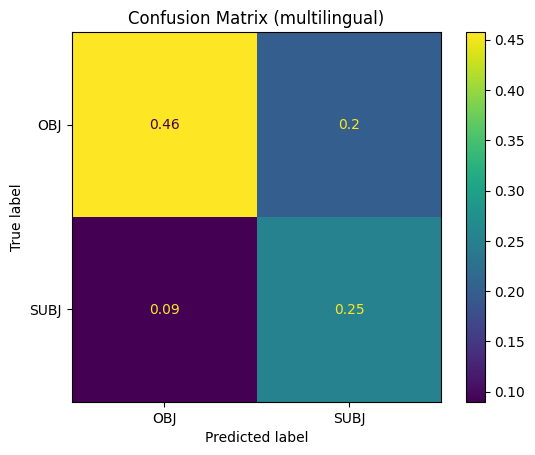

In [85]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results['multi'] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix (multilingual)")
plt.show()

In [86]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german,0.821719,0.813920,0.834768,0.769874,0.718750,0.828829,0.836795
bulgarian,0.759120,0.766044,0.756029,0.712871,0.757895,0.672897,0.768000
italian,0.704794,0.709662,0.767319,0.623656,0.491525,0.852941,0.727096
multi,0.697407,0.696923,0.716596,0.635383,0.558294,0.737171,0.710120
english,0.660991,0.675156,0.652296,0.477477,0.530000,0.434426,0.760331
baseline-english,0.632868,0.632868,0.632868,0.450820,0.450820,0.450820,0.723140
baseline-italian,0.632050,0.629487,0.656606,0.501511,0.425641,0.610294,0.678363
baseline-multi,0.622001,0.622323,0.633497,0.538037,0.480788,0.610763,0.640652
arabic,0.553828,0.580707,0.564025,0.418426,0.550505,0.337461,0.594920


---

# ModernBERT-base (English)

In [132]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5145

In [133]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [134]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [135]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [136]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

In [137]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.580005,0.690359,0.693167,0.692286,0.684327,0.727700,0.645833,0.690476
2,No log,0.534539,0.724166,0.724956,0.723930,0.740286,0.726908,0.754167,0.725108
3,No log,0.735870,0.695320,0.707796,0.700901,0.672897,0.765957,0.600000,0.696970
4,No log,0.766969,0.724890,0.724838,0.725113,0.732632,0.740426,0.725000,0.725108
5,No log,1.071517,0.702726,0.710195,0.706475,0.687927,0.758794,0.629167,0.703463
6,No log,1.047840,0.703395,0.705800,0.705124,0.698901,0.739535,0.662500,0.703463


TrainOutput(global_step=312, training_loss=0.26149874467116135, metrics={'train_runtime': 136.5187, 'train_samples_per_second': 36.479, 'train_steps_per_second': 2.285, 'total_flos': 473959555589520.0, 'train_loss': 0.26149874467116135, 'epoch': 6.0})

{'macro_F1': 0.7069330911292766, 'macro_P': 0.713565668202765, 'macro_R': 0.7014763155511277, 'SUBJ_F1': 0.5555555555555557, 'SUBJ_P': 0.5803571428571429, 'SUBJ_R': 0.5327868852459017, 'accuracy': 0.7851239669421488}


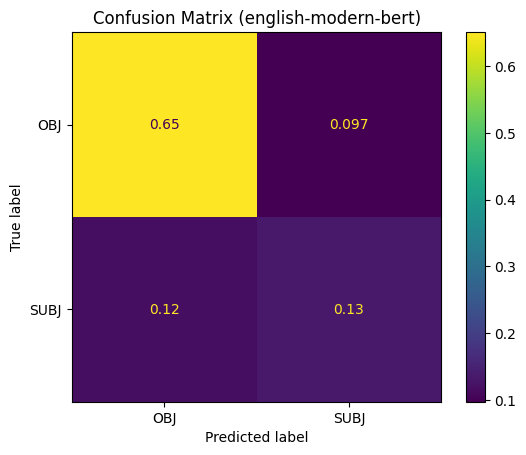

In [142]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results['english-modern-bert'] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix (english-modern-bert)")
plt.show()

In [140]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german,0.821719,0.813920,0.834768,0.769874,0.718750,0.828829,0.836795
bulgarian,0.759120,0.766044,0.756029,0.712871,0.757895,0.672897,0.768000
english-sentiment,0.725210,0.718433,0.734082,0.596899,0.566176,0.631148,0.785124
english-modern-bert,0.706933,0.713566,0.701476,0.555556,0.580357,0.532787,0.785124
italian,0.704794,0.709662,0.767319,0.623656,0.491525,0.852941,0.727096
multi,0.697407,0.696923,0.716596,0.635383,0.558294,0.737171,0.710120
english,0.660991,0.675156,0.652296,0.477477,0.530000,0.434426,0.760331
baseline-english,0.632868,0.632868,0.632868,0.450820,0.450820,0.450820,0.723140
baseline-italian,0.632050,0.629487,0.656606,0.501511,0.425641,0.610294,0.678363
baseline-multi,0.622001,0.622323,0.633497,0.538037,0.480788,0.610763,0.640652


---

# Llama-3.2-1B (English)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "meta-llama/Llama-3.2-1B" # meta-llama/Meta-Llama-3-8B

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = False, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_card, add_prefix_space=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card,
    quantization_config=quantization_config,
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
model = prepare_model_for_kbit_training(model)
model

In [ ]:
model = get_peft_model(model, lora_config)
model

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-4
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir="Llama-3.2-1B-subjectivity-english",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="macro_F1",
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

In [ ]:
trainer.train()

In [ ]:
predictions, labels, _ = trainer.predict(test_data)
evaluate_metrics((predictions, labels))

---

# Deepseek-llm-7b-base

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "deepseek-ai/deepseek-llm-7b-base"

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

lora_config = LoraConfig(
    r = 8, # the dimension of the low-rank matrices
    lora_alpha = 32, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_card)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card,
    quantization_config=quantization_config,
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
model = get_peft_model(model, lora_config)
model

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
language = 'english'

epochs = 6
batch_size = 4
lr = 1e-4
weight_decay = 0.1

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir="deepseek-llm-7b-base-subjectivity-english",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    #gradient_accumulation_steps=16,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="macro_F1",
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
    weights_dtype=torch.float16,
)

In [ ]:
trainer.train()

In [ ]:
predictions, labels, _ = trainer.predict(test_data)
evaluate_metrics((predictions, labels))

# Test - Translating Arab to English

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

In [ ]:
language = 'italian'

In [ ]:
!ct2-transformers-converter --model Helsinki-NLP/opus-mt-it-en --output_dir opus-mt-it-en

In [ ]:
import ctranslate2
import transformers

translator = ctranslate2.Translator("opus-mt-it-en", device='cuda')
tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-it-en")

def translate_text(raw_text):
    source = tokenizer.convert_ids_to_tokens(tokenizer.encode(raw_text))
    results = translator.translate_batch([source])
    target = results[0].hypotheses[0]
    translation = tokenizer.decode(tokenizer.convert_tokens_to_ids(target))
    return translation

tqdm.pandas() # display tqdm on pandas apply functions

In [ ]:
detector.all_data[language]['train']['translated_sentence'] = detector.all_data[language]['train']['sentence'].progress_apply(translate_text)

In [ ]:
detector.all_data[language]['dev']['translated_sentence'] = detector.all_data[language]['dev']['sentence'].progress_apply(translate_text)

In [ ]:
detector.all_data[language]['test']['translated_sentence'] = detector.all_data[language]['test']['sentence'].progress_apply(translate_text)

In [ ]:
detector.all_data[language]['train'].to_csv('/kaggle/working/train_it.csv')
detector.all_data[language]['dev'].to_csv('/kaggle/working/dev_it.csv')
detector.all_data[language]['test'].to_csv('/kaggle/working/dev_test_it.csv')

In [ ]:
detector.all_data[language]['train'] = pd.read_csv('/kaggle/working/train_it.csv')
detector.all_data[language]['dev'] = pd.read_csv('/kaggle/working/dev_it.csv')
detector.all_data[language]['test'] = pd.read_csv('/kaggle/working/dev_test_it.csv')

In [ ]:
epochs = 6
batch_size = 16
lr = 6e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

def tokenize_text(texts):
    return tokenizer(texts['translated_sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="macro_F1",
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
    weights_dtype=torch.float32,
)

In [ ]:
trainer.train()

In [ ]:
predictions, labels, _ = trainer.predict(test_data)
evaluate_metrics((predictions, labels))

---

# ModernBERT-base (english + sentiment)

In [158]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5129

In [159]:
from transformers import DebertaV2Model, ModernBertModel, DebertaV2Config, ModernBertConfig, pipeline 

class CustomModel(nn.Module):
    def __init__(self, model_name="microsoft/mdeberta-v3-base", num_labels=2, sentiment_dim=3):
        super().__init__()
        self.model = ModernBertModel.from_pretrained(model_name)
        self.config = ModernBertConfig
        hidden_size = self.model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + sentiment_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        pooled_output = last_hidden_state[:, 0, :]  # Prendiamo il token [CLS] (prima posizione)
        
        # Concatenate with sentiment features
        positive = positive.unsqueeze(1)
        neutral = neutral.unsqueeze(1)
        negative = negative.unsqueeze(1)
        sentiment_features = torch.cat((positive, neutral, negative), dim=1)
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Pass through custom classification head
        logits = self.classifier(combined_features)
        
        return {'logits': logits}

In [160]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = CustomModel(
    model_name=model_card, 
    num_labels=2, 
    sentiment_dim=3
)

In [161]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 484/484 [00:04<00:00, 116.98it/s]


In [162]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [163]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [164]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
    weights_dtype=torch.float32,
)

In [165]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.608540,0.680186,0.691697,0.685642,0.657343,0.746032,0.587500,0.681818
2,No log,0.550459,0.722906,0.733654,0.723480,0.757692,0.703571,0.820833,0.727273
3,No log,0.647629,0.710819,0.712191,0.710586,0.730223,0.711462,0.750000,0.712121
4,No log,0.834232,0.711731,0.711700,0.711768,0.722338,0.723849,0.720833,0.712121
5,No log,0.938603,0.718567,0.718905,0.719200,0.722222,0.741228,0.704167,0.718615
6,No log,1.010321,0.699020,0.699134,0.699437,0.704883,0.718615,0.691667,0.699134


TrainOutput(global_step=312, training_loss=0.28039863782051283, metrics={'train_runtime': 136.2225, 'train_samples_per_second': 36.558, 'train_steps_per_second': 2.29, 'total_flos': 0.0, 'train_loss': 0.28039863782051283, 'epoch': 6.0})

{'macro_F1': 0.7252101757833824, 'macro_P': 0.7184330628803246, 'macro_R': 0.734082057784621, 'SUBJ_F1': 0.5968992248062016, 'SUBJ_P': 0.5661764705882353, 'SUBJ_R': 0.6311475409836066, 'accuracy': 0.7851239669421488}


training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

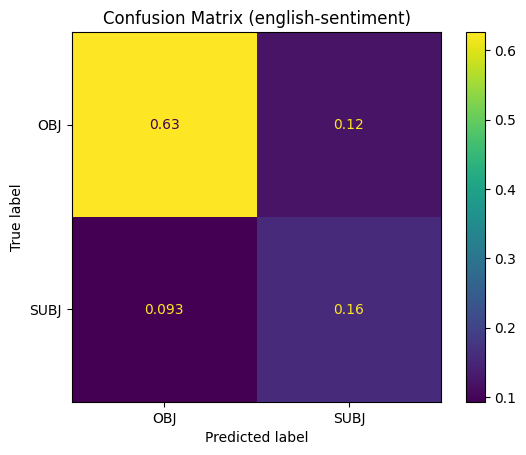

In [166]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results['english-sentiment'] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix (english-sentiment)")
plt.show()

---

# mdeberta-v3-base (german + sentiment)

In [176]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


3890

In [177]:
from transformers import DebertaV2Model, ModernBertModel, DebertaV2Config, ModernBertConfig, pipeline 

class CustomModel(nn.Module):
    def __init__(self, model_name="microsoft/mdeberta-v3-base", num_labels=2, sentiment_dim=3):
        super().__init__()
        self.model = DebertaV2Model.from_pretrained(model_name)
        self.config = DebertaV2Config
        hidden_size = self.model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + sentiment_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        pooled_output = last_hidden_state[:, 0, :]  # Prendiamo il token [CLS] (prima posizione)
        
        # Concatenate with sentiment features
        positive = positive.unsqueeze(1)
        neutral = neutral.unsqueeze(1)
        negative = negative.unsqueeze(1)
        sentiment_features = torch.cat((positive, neutral, negative), dim=1)
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Pass through custom classification head
        logits = self.classifier(combined_features)
        
        return {'logits': logits}

In [178]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = CustomModel(
    model_name=model_card, 
    num_labels=2, 
    sentiment_dim=3
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [179]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 337/337 [00:02<00:00, 120.73it/s]


In [180]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [185]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [186]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
    weights_dtype=torch.float32,
)

In [187]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.644036,0.695078,0.719348,0.686628,0.578947,0.676923,0.505747,0.739308
2,No log,0.563238,0.721352,0.723305,0.743555,0.674817,0.587234,0.793103,0.729124
3,No log,0.551821,0.692941,0.721037,0.736185,0.671053,0.542553,0.879310,0.694501
4,No log,0.534766,0.768234,0.763597,0.776787,0.711590,0.670051,0.758621,0.782077
5,No log,0.553367,0.764540,0.761985,0.767713,0.700280,0.683060,0.718391,0.782077
6,No log,0.537430,0.761987,0.757429,0.770759,0.704301,0.661616,0.752874,0.775967


TrainOutput(global_step=300, training_loss=0.4640718078613281, metrics={'train_runtime': 181.0084, 'train_samples_per_second': 26.518, 'train_steps_per_second': 1.657, 'total_flos': 0.0, 'train_loss': 0.4640718078613281, 'epoch': 6.0})

{'macro_F1': 0.8223817235728728, 'macro_P': 0.8142140468227425, 'macro_R': 0.8370605118392729, 'SUBJ_F1': 0.7717842323651452, 'SUBJ_P': 0.7153846153846154, 'SUBJ_R': 0.8378378378378378, 'accuracy': 0.8367952522255193}


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

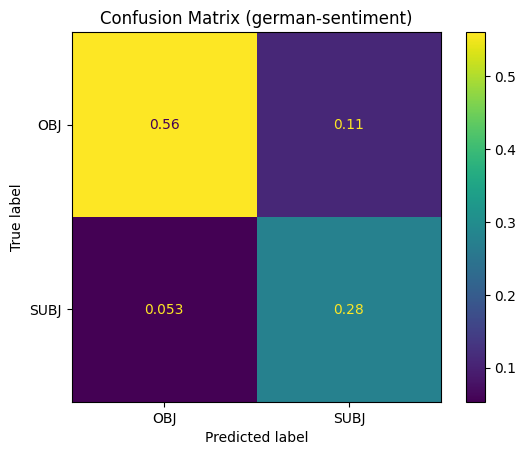

In [188]:
test_predictions, test_labels, _ = trainer.predict(test_data)

stats = evaluate_metrics((test_predictions, test_labels))

test_predictions = np.argmax(test_predictions, axis=1)

print(stats)
results[f'{language}-sentiment'] = stats

trainer.push_to_hub()

cm = confusion_matrix(test_labels, test_predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language}-sentiment)")
plt.show()

In [189]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german-sentiment,0.822382,0.814214,0.837061,0.771784,0.715385,0.837838,0.836795
german,0.821719,0.813920,0.834768,0.769874,0.718750,0.828829,0.836795
bulgarian,0.759120,0.766044,0.756029,0.712871,0.757895,0.672897,0.768000
english-sentiment,0.725210,0.718433,0.734082,0.596899,0.566176,0.631148,0.785124
english-modern-bert,0.706933,0.713566,0.701476,0.555556,0.580357,0.532787,0.785124
italian,0.704794,0.709662,0.767319,0.623656,0.491525,0.852941,0.727096
multi,0.697407,0.696923,0.716596,0.635383,0.558294,0.737171,0.710120
english,0.660991,0.675156,0.652296,0.477477,0.530000,0.434426,0.760331
baseline-english,0.632868,0.632868,0.632868,0.450820,0.450820,0.450820,0.723140
baseline-italian,0.632050,0.629487,0.656606,0.501511,0.425641,0.610294,0.678363
